# Create the Training Data

Load the SDG related and non-SDG related data. 
Cleansing contains: 
- nan removal 
- renaming of columns 
- drop redundant features
- split data to sentences tokenizer
- manual cleaning of sentences
    - contatenating wrongly split sentences at "e.g. "
    - removing formatting issues from PDF parsing
- concatenating the general and sdg datasets. 

Datasources: <br> 
General Data: https://www.kaggle.com/mikeortman/wikipedia-sentences <br>
SDG Data: Various resources from United Nations 

In [42]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import seaborn as sns
import re

In [46]:
# load SDG data
df = pd.read_excel('./datasets/SDG_text.xlsx', None, engine='openpyxl')
sheets = list(df.keys())
num_classes = len(sheets)
dfs = list()
for sheet in sheets: 
    df = pd.read_excel('./datasets/SDG_text.xlsx', sheet, engine='openpyxl')
    df['class'] = int(sheet[-2:])
    dfs.append(df)
    
df = pd.concat(dfs)

In [47]:
df.shape

(225, 3)

In [48]:
df = df.dropna()

In [49]:
df.shape

(172, 3)

**Question**: need to sample 512 tokens statically - then it can be done here - or dynammically - then it needs to be done at a later stage.

In [50]:
df = df.reset_index(drop=True)

In [51]:
df.drop(['Source'], inplace=True, axis=1)

In [52]:
df.head()

,Text,class
0,End poverty in all its forms everywhere. By 20...,1
1,"Despite progress under the MDGs, approximately...",1
2,Even before the coronavirus disease (COVID-19)...,1
3,"The decline of extreme poverty continues, but ...",1
4,Giving people in every part of the world the s...,1


In [53]:
# split sentences and output each sentence and its classfication 
# in a separate file for manual cleansing
df_train = pd.DataFrame(columns=['sentence', 'class'])
counter = 0
def split_sentences(text, label):
    global counter 
    sentences = sent_tokenize(text)
    for sentence in sentences: 
        row = [sentence + '. ', label]
        df_train.loc[counter] = row
        counter += 1

In [54]:
df.apply(lambda x: split_sentences(x[0], x[1]), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
167    None
168    None
169    None
170    None
171    None
Length: 172, dtype: object

In [56]:
df_train

,sentence,class
0,End poverty in all its forms everywhere..,1
1,"By 2030, eradicate extreme poverty for all peo...",1
2,"By 2030, reduce at least by half the proportio...",1
3,Implement nationally appropriate social protec...,1
4,"By 2030, ensure that all men and women, in par...",1
...,...,...
5166,Adopting responsible business practices and co...,17
5167,But tackling some of the toughest global chall...,17
5168,Working in partnership can often lead to great...,17
5169,"With its reach and unique capabilities, busine...",17


In [58]:
df_train.to_csv('./datasets/training_sdg.csv', index=False)

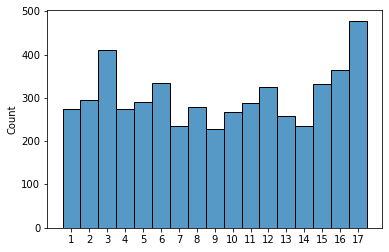

In [57]:
sns_histplot = sns.histplot(sorted([label for int_label in df_train['class'] for label in re.findall(r"[\w']+", str(int_label))], key=int))


### Import general text data from wikiedia file

In [59]:
# load general wikipedia data
df_wiki = pd.read_csv('/Users/martinthoma/Desktop/codebase_thesis/datasets/wikisent2.txt', delimiter='\t', header=None)

In [60]:
df_wiki.head()

,0
0,"0.000123, which corresponds to a distance of 7..."
1,"000webhost is a free web hosting service, oper..."
2,"0010x0010 is a Dutch-born audiovisual artist, ..."
3,0-0-1-3 is an alcohol abuse prevention program...
4,"0.01 is the debut studio album of H3llb3nt, re..."


In [62]:
# shuffle data randomly before slicing
df_wiki = df_wiki.sample(frac=1).reset_index(drop=True)

In [69]:
df_wiki = df_wiki.iloc[:600, :]
df_wiki.columns = ['sentence']

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [70]:
df_wiki['label'] = 0

In [71]:
df_wiki.head()

,sentence,label
0,"It is broadcast from Jhelum, Islamabad, Sargod...",0
1,It was written by Hanif Kureishi from his shor...,0
2,Kohn retired from competition after the 2010 W...,0
3,It spent 30 weeks on the AIR Indie Charts and ...,0
4,For a time he was also the manager of Pacific ...,0


In [72]:
df_wiki.to_csv('./datasets/general_text.csv', index=False)

### Load Indeed Dev Test data

In [59]:
df_dev_test = pd.read_excel('./datasets/dev_test_set_u_prelabelled_labelled_2000.xlsx')

In [60]:
df_dev_test.head()

,id,comp_name,sentence,model_most_likely,human_label
0,07e45bf1b3a39e5d,engie,ENGIE are recruiting for a Mobile Contract Sup...,0.0,0
1,07e45bf1b3a39e5d,engie,"This is a permanent, full time role working 40...",0.0,0
2,07e45bf1b3a39e5d,engie,"On offer is a salary of ¬£35,000 - ¬£37,500 de...",0.0,1
3,07e45bf1b3a39e5d,engie,Provide Technical Assistance to other Engineer...,0.0,0
4,07e45bf1b3a39e5d,engie,Maintain all PPM and Reactive Repairs Records ...,0.0,0


In [61]:
df_indeed_train = df_dev_test.loc[~df_dev_test['human_label'].isnull(), :]

In [62]:
df_indeed_train = df_indeed_train[['sentence', 'human_label']]

In [63]:
df_indeed_train.columns = ['sentence', 'label']

In [64]:
df_indeed_train.head()

,sentence,label
0,ENGIE are recruiting for a Mobile Contract Sup...,0
1,"This is a permanent, full time role working 40...",0
2,"On offer is a salary of ¬£35,000 - ¬£37,500 de...",1
3,Provide Technical Assistance to other Engineer...,0
4,Maintain all PPM and Reactive Repairs Records ...,0


In [65]:
df_indeed_train.to_csv('./datasets/dev_test_set_u_2000_train.csv', index=False)

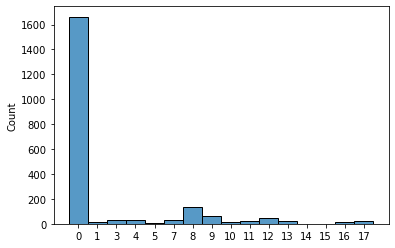

In [76]:
sns_histplot = sns.histplot(sorted([label for int_label in df_indeed_train['label'] for label in re.findall(r"[\w']+", str(int_label))], key=int))


### Concatenate other and SDG data to training set

In [71]:
# load clean versions of the datasets 
# and concatenate them
#df_general = pd.read_csv('./datasets/general_text.csv')
df_sdg = pd.read_csv('./datasets/training_sdg.csv')
df_indeed = pd.read_csv('./datasets/dev_test_set_u_2000_train.csv')

df_indeed.columns = df_sdg.columns = ['sentence', 'labels']
df = pd.concat([df_indeed, df_sdg])

In [72]:
# Check success of concatenation
print('Concat Successfully: ' + str(df_indeed.shape[0] + df_sdg.shape[0] == df.shape[0]))

Concat Successfully: True


In [73]:
# shuffle and save data to disk 
df = df.sample(frac=1).reset_index(drop=True)
df.to_csv('./datasets/training_set_sdg_indeed_2000_imbalanced.csv', index=False)

### Look at label balance and balance out if needed

In [79]:
df_train_unbalanced = pd.read_csv('./datasets/training_set_sdg_indeed_2000_imbalanced.csv')

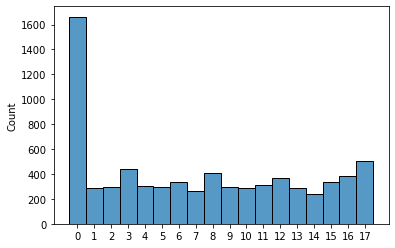

In [81]:
sns_histplot = sns.histplot(sorted([label for int_label in df_train_unbalanced['labels'] for label in re.findall(r"[\w']+", str(int_label))], key=int))


In [82]:
nb_label_max = 800

In [84]:
d_label_cunts = {'SDG ' + str(n): 0 for n in range(19)} 

In [ ]:
df_train_unbalanced['is_balanced'] = 